In [1]:
# -*- coding: utf-8 -*-
from datetime import date
import numpy as np
from dateutil.parser import parse
import pandas as pd
from WMBYPlatform import StrategyPlatform
import pandas as pd
from alphanet import AlphaNetV2, AlphaNetV3, AlphaNetV4, load_model
from src.alphanet.data import TrainValData, TimeSeriesData
from alphanet.metrics import UpDownAccuracy
import tensorflow as tf
import os

2022-04-17 13:47:47.635098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-17 13:47:47.635141: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
def loading_Data(stocks_path):
    sp = StrategyPlatform()
    sp.SetStockListByCSVFile(stocks_path)  
    today = int(date.today().strftime('%Y%m%d'))
    sp.SetDate(20180101, today) # 20180101 为固定值 不能修改，否则和 all_date 不匹配

    close_df = sp.LoadData('ashare', 'S_DQ_ADJCLOSE').replace(0, np.nan)
    Open_df = sp.LoadData('ashare', 'S_DQ_ADJOPEN').replace(0, np.nan)
    high_df = sp.LoadData('ashare', 'S_DQ_ADJHIGH').replace(0, np.nan)
    low_df = sp.LoadData('ashare', 'S_DQ_ADJLOW').replace(0, np.nan)
    volume_df = sp.LoadData('ashare', 'S_DQ_VOLUME').replace(0, np.nan)
    vwap_df = sp.LoadData('ashare', 'S_DQ_AVGPRICE').replace(0, np.nan)
    turn_df = sp.LoadData('ashare', 'S_DQ_TURN').replace(0, np.nan)
    free_turn_df = sp.LoadData('ashare', 'S_DQ_FREETURNOVER').replace(0, np.nan)
    returns1_df = close_df.pct_change(1)
    close_free_turn_df = close_df / free_turn_df
    open_turn_df = Open_df / turn_df
    volume_low_df = vwap_df / low_df
    vwap_high_df = vwap_df / high_df
    low_high_df = low_df / high_df
    vwap_close_df = vwap_df / close_df

    returns_label = close_df.pct_change(10)

    stock_data_list = []
    for i in close_df.columns[:]:
        open_data = Open_df[i].rename('open_' + i)
        high_data = high_df[i].rename('high_' + i)
        low_data = low_df[i].rename('low_' + i)
        close_data = close_df[i].rename('close_' + i)
        volume_data = volume_df[i].rename('volume_' + i)
        vwap_data = vwap_df[i].rename('vwap_' + i)
        return1_data = returns1_df[i].rename('return_' + i)
        turn_data = turn_df[i].rename('turn_' + i)
        free_turn_data = free_turn_df[i].rename('free_turn_' + i)
        close_free_turn_data = close_free_turn_df[i].rename('CFT_' + i)
        open_turn_data = open_turn_df[i].rename('OT_' + i)
        volume_low_data = volume_low_df[i].rename('VL_' + i)
        vwap_high_data = vwap_high_df[i].rename('VH_' + i)
        low_high_data = low_high_df[i].rename('LH_' + i)
        vwap_close_data = vwap_close_df[i].rename('VC_' + i)
        stock = pd.DataFrame(
            [open_data, high_data, low_data, close_data, vwap_data, volume_data, return1_data, turn_data,
             free_turn_data,close_free_turn_data, open_turn_data, volume_low_data, vwap_high_data, low_high_data,
             vwap_close_data])

        date_table = stock.columns[:]
        stock_table = stock.iloc[:, :]
        ret = returns_label[i][:]

        DSR = TimeSeriesData(dates=date_table.values,
                             data=stock_table.values.T,
                             labels=ret.values)
        stock_data_list.append(DSR)

    print('------loading data finish------')
    return stock_data_list, date_table, returns_label.shape[1], returns_label.shape[0]


def get_rolling_testing_set(test_gap, start_day, stock_data):
    train_val_data = TrainValData(time_series_list=stock_data,
                                  train_length=31,
                                  validate_length=test_gap,
                                  history_length=30,
                                  sample_step=1,
                                  train_val_gap=10)
    train, val, dates_info = train_val_data.get(start_day, order="by_date")
    befor_start_predicting_day = dates_info['validation']['start_date']
    #print('start_date',dates_info['validation']['start_date'])
    #print('end_date',dates_info['validation']['end_date'])
    return train, val, dates_info, befor_start_predicting_day


def cal_alphanet_factor(stock_pool_path):
    stock_pool = stock_pool_path.split('/')[-1].split('_')[0]
    
    stock_data_list, date_table, stocks_length, date_length  = loading_Data(stock_pool_path)
   
    predict_day = 20211231
    input_start_day = int(date_table[(np.where(date_table==predict_day)[0][0])-41])
    gap = len(date_table) - np.where(date_table==predict_day)[0][0]

    train_data, val_data, dates_inf , predict_time = get_rolling_testing_set(int(gap), input_start_day, stock_data_list)
    # print(dates_inf)

    model = AlphaNetV2(l2=0.001, dropout=0.0)
    model.compile(metrics=[tf.keras.metrics.RootMeanSquaredError(), UpDownAccuracy()])

    predict = []
    for j in range(0, 5):
        model.load_weights('/data/home/qianjian/AlphaNet/weights/%s/AlphaNetV2_%s_20211231_%d' % (stock_pool,stock_pool,j))
        _y_predict = model.predict(val_data.batch(500).cache()).flatten().tolist()
        predict.append(_y_predict)
    print('------predicting data finish------')
    y_predict_ = np.array(predict).mean(axis=0).flatten()

    not_nan = np.load('not_nan.npy', allow_pickle=True).tolist()
    trans_val = []
    pointer = 0
    for x in not_nan:
        if x:
            trans_val.append(y_predict_[pointer])
            pointer += 1
        else:
            trans_val.append(np.nan)

    factor_2022 = np.array(trans_val).reshape((int(gap), stocks_length)).tolist()
    
    factor = np.load('/data/home/qianjian/AlphaNet/factor/%s_factor_20171229_20211230.npy'%(stock_pool), allow_pickle=True).tolist()
   
    factor.extend(factor_2022)
    print('------got all factors------')
    return factor,date_table


def load_stocks_pool(stock_name):
    path = '/data/home/qianjian/AlphaNet/常用股票池'
    list_of_gesture = [os.path.join(path, per_path) for per_path in os.listdir(path)]
    for i_path in list_of_gesture:
        if stock_name == i_path.split('/')[-1].split('_')[0]:
            stock_path = i_path    
    return stock_path


In [15]:
def get_alphanet_factors(_day_list ,_stock_name):
    stock_pool_name = load_stocks_pool(_stock_name)
    print('正在使用的股票池为：',stock_pool_name)
    all_factor,all_date = cal_alphanet_factor(stock_pool_name)
    all_factor_pd = pd.DataFrame(all_factor[1:],  index = all_date)
    input_factor = all_factor_pd.loc[_day_list]
    return  input_factor, all_factor_pd


day_list = [20220414,20220415] # 交易日列表 格式[20220412,20220413]
stock_name = 'lugutong' # 输入的格式为'lugutong', 'zz500', 'ashare', 'hs300' 中任意一个


day_list_factor, all_factor = get_alphanet_factors(day_list,stock_name)

print(len(day_list_factor), len(day_list_factor[0]))
print(day_list_factor)

正在使用的股票池为： /data/home/qianjian/AlphaNet/常用股票池/lugutong_20220219.csv
loading S_DQ_ADJCLOSE [20180102,20220418]
loading S_DQ_ADJOPEN [20180102,20220418]
loading S_DQ_ADJHIGH [20180102,20220418]
loading S_DQ_ADJLOW [20180102,20220418]
loading S_DQ_VOLUME [20180102,20220418]
loading S_DQ_AVGPRICE [20180102,20220418]
loading S_DQ_TURN [20180102,20220418]
loading S_DQ_FREETURNOVER [20180102,20220418]
------loading data finish------
------predicting data finish------
------got all factors------
2 2
              0         1         2         3         4         5     \
20220414 -0.008585  0.032485  0.019299  0.023794  0.019890  0.036294   
20220415 -0.029845 -0.003147 -0.000026  0.020977  0.020901 -0.025004   

              6         7         8         9     ...      1475      1476  \
20220414 -0.003726  0.028321 -0.023384  0.023111  ...  0.007389  0.050871   
20220415  0.018640  0.019277 -0.040517  0.011482  ...  0.003011 -0.011732   

              1477      1478      1479      1480      

Int64Index([20180102, 20180103, 20180104, 20180105, 20180108, 20180109,
            20180110, 20180111, 20180112, 20180115,
            ...
            20211220, 20211221, 20211222, 20211223, 20211224, 20211227,
            20211228, 20211229, 20211230, 20211231],
           dtype='int64', length=973)
(972, 1485) 972 1485
loading S_DQ_ADJCLOSE [20180103,20220104]
loading S_DQ_LOW [20180103,20220104]
loading S_DQ_HIGH [20180103,20220104]
loading S_DQ_ADJOPEN [20180103,20220104]
loading S_DQ_OPEN [20180103,20220104]
loading S_DQ_TRADESTATUS_SIG [20180103,20220104]
loading S_DQ_PRECLOSE [20180103,20220104]
loading S_DQ_ADJPRECLOSE [20180103,20220104]
loading S_DQ_AVGPRICE [20180103,20220104]
loading S_DQ_ADJFACTOR [20180103,20220104]


run backtest:   0%|          | 0/971 [00:00<?, ?it/s]

+----------+----------+----------+----------+----------+----------+----------+----------+--------------+------------+
| 回测收益 | 多头年化 | 基准年化 | 多头夏普 | 最大回撤 | 超额年化 | 跟踪误差 | 超额夏普 | 超额最大回撤 | 日均换手率 |
+----------+----------+----------+----------+----------+----------+----------+----------+--------------+------------+
|  86.37%  |  21.77%  |  6.05%   |   0.88   | -35.17%  |  15.72%  |  6.95%   |   2.26   |    -8.75%    |   19.51%   |
+----------+----------+----------+----------+----------+----------+----------+----------+--------------+------------+


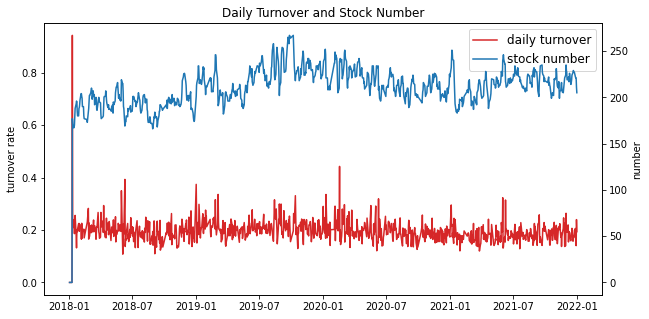

In [16]:
sp = StrategyPlatform()
# sp.SetStockListByCSVFile("常用股票池/zz500_20211210.csv") 
# sp.SetStockListByCSVFile("常用股票池/ashare_20211130.csv")  
# sp.SetStockListByCSVFile("常用股票池/hs300_20211210.csv")
sp.SetStockListByCSVFile("常用股票池/lugutong_20220219.csv")

today = int(date.today().strftime('%Y%m%d'))
sp.SetDate(20180103, 20211231)

print(all_factor[0:973].index)
factor_rank = all_factor[0:972].rank(axis=1, pct=True).values

print(factor_rank.shape,len(factor_rank), len(factor_rank[0]))
alpha_dict = np.zeros((len(factor_rank), len(factor_rank[0])))
alpha_dict[factor_rank > 0.95] = 1
alpah_MA = pd.DataFrame(alpha_dict).rolling(7).mean().to_numpy()
alpah_MA[alpah_MA > 0] = 1
sp.GeneratePerformanceAshare(alpah_MA, show_daily_turnover=True)

# # np.save('factor/lugutong_alpha_20180102_20220412_MA7.npy', alpah_MA)
# # 策略效果
# alpha = np.load('factor/lugutong_alpha_20180102_20220412_MA7.npy')
# sp.GeneratePerformanceAshare(alpha, show_daily_turnover=True)